<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/VGG16_optimal%2BCNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.9 MB/s eta 0:00:00


In [25]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
import pickle

path = '/gdrive/My Drive/data/mature_train_labeled.pkl'

with open(path, 'rb') as f:
    mature = pickle.load(f)
    print('mature : ', len(mature))

mature :  2000


In [5]:
import pickle

path = '/gdrive/My Drive/data/incipient_train_labeled.pkl'

with open(path, 'rb') as f:
    incipient = pickle.load(f)
    print('incipient : ', len(incipient))

incipient :  2000


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

mature_train_labeled_list = []
for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_train_labeled_list.append(np.array(zero_centering_value, dtype=np.float32))

# 리스트를 NumPy 배열로 변환
mature_train_labeled_value = np.array(mature_train_labeled_list)

print("mature_train_labeled_value shape:", mature_train_labeled_value.shape)

mature_train_labeled_value shape: (2000, 224, 224, 3)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

incipient_train_labeled_list = []
for file, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_train_labeled_list.append(np.array(zero_centering_value, dtype=np.float32))


# 리스트를 NumPy 배열로 변환
incipient_train_labeled_value = np.array(incipient_train_labeled_list)

print("incipient_train_labeled_value shape:", incipient_train_labeled_value.shape)

incipient_train_labeled_value shape: (2000, 224, 224, 3)


In [8]:
X = np.concatenate((incipient_train_labeled_value, incipient_train_labeled_value), axis=0)
y = np.concatenate((np.zeros(incipient_train_labeled_value.shape[0]), np.ones(incipient_train_labeled_value.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2800, 224, 224, 3)
(600, 224, 224, 3)
(600, 224, 224, 3)


y one-hot

In [10]:
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_val_one_hot = to_categorical(y_val, num_classes=2)
y_test_one_hot = to_categorical(y_test)

# Hyperparameter tuning

In [11]:
# memory reduce
del mature, incipient
del mature_train_labeled_value, incipient_train_labeled_value
del mature_train_labeled_list, incipient_train_labeled_list
del X, y
del y_train, y_temp, y_val, y_test

In [12]:

def objective(trial, X_train, y_train, X_val, y_val):
    # Define parameters to be tuned
    # 여기서 lr, epochs, batch_size가 하이퍼파라미터튜닝 대상입니다.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate
    epochs = 10
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size

    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    model = Sequential([
        base_model,
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(2, activation='softmax')  # Assuming 2 classes for classification
    ])

    # Compile model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    return val_loss


In [13]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train_one_hot, X_val, y_val_one_hot), n_trials=5)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-05-18 10:37:23,113] A new study created in memory with name: no-name-6ed843eb-2735-405a-9be8-69ae773476be
<ipython-input-12-42a19bcb1f70>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate


58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/10
44/44 [==============================] - 12s 146ms/step - loss: 4.0052 - accuracy: 0.5029 - val_loss: 0.7049 - val_accuracy: 0.4983
Epoch 2/10
44/44 [==============================] - 3s 59ms/step - loss: 0.7003 - accuracy: 0.5036 - val_loss: 0.6942 - val_accuracy: 0.5033
Epoch 3/10
44/44 [==============================] - 3s 59ms/step - loss: 0.6940 - accuracy: 0.5107 - val_loss: 0.6951 - val_accuracy: 0.4983
Epoch 4/10
44/44 [==============================] - 3s 58ms/step - loss: 0.6955 - accuracy: 0.4982 - val_loss: 0.6967 - val_accuracy: 0.4683
Epoch 5/10
44/44 [==============================] - 3s 59ms/step - loss: 0.6944 - accuracy: 0.5104 - val_loss: 0.6925 - val_accuracy: 0.5217
Epoch 6/10
44/44 [==============================] - 3s 58ms/step - loss: 0.7013 - accuracy: 0.5007 - val_loss: 0.6978 - val_accuracy: 0.4983
Epoch 7/10
44/44 [==============================] - 3s 59ms/step - loss: 0.6954 - accuracy: 0.5093 - val_loss: 0.6989 - val_accuracy: 0.5017
Epoch 8/10


[I 2024-05-18 10:38:02,548] Trial 0 finished with value: 0.6932610273361206 and parameters: {'lr': 0.00020882770424517013, 'batch_size': 64}. Best is trial 0 with value: 0.6932610273361206.


Epoch 1/10
88/88 [==============================] - 7s 50ms/step - loss: 1.6684 - accuracy: 0.5068 - val_loss: 0.6979 - val_accuracy: 0.5017
Epoch 2/10
88/88 [==============================] - 3s 33ms/step - loss: 0.7075 - accuracy: 0.5132 - val_loss: 0.7011 - val_accuracy: 0.4983
Epoch 3/10
88/88 [==============================] - 3s 33ms/step - loss: 0.7020 - accuracy: 0.5068 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6972 - accuracy: 0.4979 - val_loss: 0.6936 - val_accuracy: 0.4967
Epoch 5/10
88/88 [==============================] - 3s 33ms/step - loss: 0.6935 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 6/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6934 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 8/10
88

[I 2024-05-18 10:38:38,671] Trial 1 finished with value: 0.693243145942688 and parameters: {'lr': 1.2519569422019126e-05, 'batch_size': 32}. Best is trial 1 with value: 0.693243145942688.


Epoch 1/10
44/44 [==============================] - 5s 76ms/step - loss: 4.6909 - accuracy: 0.5036 - val_loss: 0.6962 - val_accuracy: 0.4950
Epoch 2/10
44/44 [==============================] - 3s 58ms/step - loss: 0.7062 - accuracy: 0.5025 - val_loss: 0.7150 - val_accuracy: 0.5017
Epoch 3/10
44/44 [==============================] - 3s 58ms/step - loss: 0.7001 - accuracy: 0.4875 - val_loss: 0.6964 - val_accuracy: 0.4983
Epoch 4/10
44/44 [==============================] - 3s 58ms/step - loss: 0.6950 - accuracy: 0.5032 - val_loss: 0.6957 - val_accuracy: 0.5017
Epoch 5/10
44/44 [==============================] - 3s 58ms/step - loss: 0.6944 - accuracy: 0.5075 - val_loss: 0.7024 - val_accuracy: 0.4983
Epoch 6/10
44/44 [==============================] - 3s 59ms/step - loss: 0.6950 - accuracy: 0.5025 - val_loss: 0.7093 - val_accuracy: 0.5017
Epoch 7/10
44/44 [==============================] - 3s 59ms/step - loss: 0.6935 - accuracy: 0.4968 - val_loss: 0.6934 - val_accuracy: 0.4967
Epoch 8/10
44

[I 2024-05-18 10:39:08,954] Trial 2 finished with value: 0.69366055727005 and parameters: {'lr': 0.00011777781937719047, 'batch_size': 64}. Best is trial 1 with value: 0.693243145942688.


Epoch 1/10
175/175 [==============================] - 6s 27ms/step - loss: 1.5448 - accuracy: 0.4961 - val_loss: 0.7047 - val_accuracy: 0.5017
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.7017 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6939 - accuracy: 0.4932 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6946 - val_accuracy: 0.5017
Epoch 5/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6962 - val_accuracy: 0.5017
Epoch 6/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6929 - accuracy: 0.5079 - val_loss: 0.7032 - val_accuracy: 0.5017
Epoch 7/10
175/175 [==============================] - 4s 21ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017

[I 2024-05-18 10:39:50,291] Trial 3 finished with value: 0.6932090520858765 and parameters: {'lr': 2.396790266745027e-05, 'batch_size': 16}. Best is trial 3 with value: 0.6932090520858765.


Epoch 1/10
88/88 [==============================] - 5s 40ms/step - loss: 2.3157 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.5133
Epoch 2/10
88/88 [==============================] - 3s 33ms/step - loss: 0.6998 - accuracy: 0.5082 - val_loss: 0.6975 - val_accuracy: 0.5017
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 0.7106 - accuracy: 0.5014 - val_loss: 0.7077 - val_accuracy: 0.4983
Epoch 4/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6959 - accuracy: 0.4925 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/10
88/88 [==============================] - 3s 33ms/step - loss: 0.6935 - accuracy: 0.5068 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/10
88/88 [==============================] - 3s 33ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/10
88/88 [==============================] - 3s 34ms/step - loss: 0.6933 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 8/10
88

[I 2024-05-18 10:40:24,323] Trial 4 finished with value: 0.6933068633079529 and parameters: {'lr': 2.0924460694587156e-05, 'batch_size': 32}. Best is trial 3 with value: 0.6932090520858765.


Best parameters: {'lr': 2.396790266745027e-05, 'batch_size': 16}


Training & Test

In [14]:
print(study.best_params['lr'])
print(study.best_params['batch_size'])


2.396790266745027e-05
16


In [27]:
def train_vgg16_model():
  # Load pre-trained VGG16 model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add custom top layers for classification
  model = Sequential([
      base_model,
      Flatten(),
      Dense(4096, activation='relu'),
      Dense(4096, activation='relu'),
      Dense(2, activation='softmax')
  ])

  # Compile model
  # optimizer = Adam(lr=5.520238899015578e-05)
  optimizer = Adam(lr=study.best_params['lr'])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Fine-tuning: Unfreeze some layers and train the entire model with new data
  for layer in model.layers:
      if 'block5' in layer.name:  # Unfreeze layers starting from 'block5'
          layer.trainable = True

  # Define early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Train the model with early stopping
  history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=study.best_params['batch_size'], epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50)

  # Plot training history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  # Evaluate the model
  model.summary()
  test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
  print('Test accuracy:', test_acc)


Epoch 1/50
175/175 [==============================] - 6s 26ms/step - loss: 1.5787 - accuracy: 0.5039 - val_loss: 0.7219 - val_accuracy: 0.4983
Epoch 2/50
175/175 [==============================] - 4s 22ms/step - loss: 0.7156 - accuracy: 0.5021 - val_loss: 0.7187 - val_accuracy: 0.4883
Epoch 3/50
175/175 [==============================] - 4s 22ms/step - loss: 0.6944 - accuracy: 0.5068 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/50
175/175 [==============================] - 4s 22ms/step - loss: 0.6937 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 5/50
175/175 [==============================] - 4s 21ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 6/50
175/175 [==============================] - 4s 21ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/50
175/175 [==============================] - 4s 22ms/step - loss: 0.6932 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5017

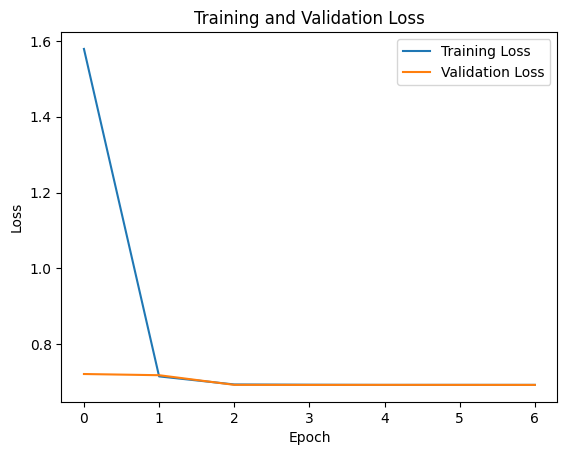

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_32 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_33 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_34 (Dense)            (None, 2)                 8194      
                                                                 
Total params: 134268738 (512.19 MB)
Trainable params: 119554050 (456.06 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
19

In [28]:
train_vgg16_model()

# CNN-LSTM

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def train_vgg16_cnn_lstm_model():
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    vgg16_model = base_model.output
    vgg16_model = Flatten()(vgg16_model)
    vgg16_model = Dense(4096, activation='relu')(vgg16_model)
    vgg16_model = Dense(4096, activation='relu')(vgg16_model)

    # Add CNN-LSTM layers
    cnn_lstm_model = Reshape((1, 4096))(vgg16_model)
    cnn_lstm_model = LSTM(256, return_sequences=True)(cnn_lstm_model)
    cnn_lstm_model = LSTM(256)(cnn_lstm_model)

    # Add output layer
    num_classes = 2  # 클래스 개수 설정
    output = Dense(num_classes, activation='softmax')(cnn_lstm_model)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    optimizer = Adam(lr=study.best_params['lr'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tuning: Unfreeze some layers and train the entire model with new data
    for layer in model.layers:
        if 'block5' in layer.name:
            # Unfreeze layers starting from 'block5'
            layer.trainable = True

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=study.best_params['batch_size'], epochs=50, callbacks=[early_stopping])

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Evaluate the model
    model.summary()
    test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
    print('Test accuracy:', test_acc)


Epoch 1/50
175/175 [==============================] - 9s 31ms/step - loss: 0.6984 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 2/50
175/175 [==============================] - 4s 22ms/step - loss: 0.6944 - accuracy: 0.5043 - val_loss: 0.6952 - val_accuracy: 0.5017
Epoch 3/50
175/175 [==============================] - 4s 22ms/step - loss: 0.6945 - accuracy: 0.5114 - val_loss: 0.6934 - val_accuracy: 0.5017
Epoch 4/50
175/175 [==============================] - 4s 24ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6937 - val_accuracy: 0.5017


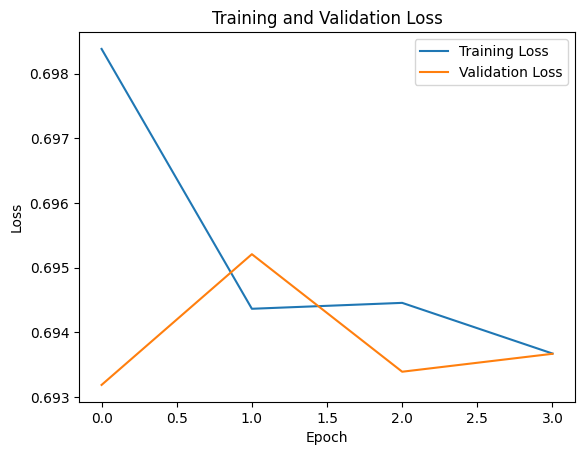

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
train_vgg16_cnn_lstm_model()